## Домашнее задание

Дедлайн 27.12.2021 23:59

### Наумов Сергей Олегович
#### М05-013


In [1]:
!pip install --user -Uq catboost

DEPRECATION: Python 3.4 support has been deprecated. pip 19.1 will be the last one supporting it. Please upgrade your Python as Python 3.4 won't be maintained after March 2019 (cf PEP 429).


In [2]:
sc.addPyFile('/opt/graphframes/graphframes-0.8.0-spark2.4-s_2.11.jar')

In [3]:
# Используемые библиотеки
from collections import defaultdict
from tqdm import tqdm
from time import time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from graphframes import GraphFrame
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType,
    IntegerType,
    StructField,
    StructType,
)
import seirsplus
from seirsplus.models import *
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
RANDOM_SEED = hash('Naumov') // int(1e13)

**Внимание!** Пожалуйста, в каждой ячейке пишите `%%time` 

---

### №1: Написать реализацию модели SIRS при помощи

1. Хранения состояний в оперативной памяти (10%)
2. Перезаписи состояний в hdfs (15%)

Построить график времени работы алгоритма от размера графа. (7%)

NOTE: Рекомендуется брать графы размеров от 100 до 5000

NOTE: генерировать графы так, как мы делали на семинаре. В качестве seed взять hash('Second_name') // int(1e13).

#### 1.1 Реализация с хранением состояния в оперативной памяти

In [4]:
%%time

N = 1000
G = nx.gaussian_random_partition_graph(n=N,                # Число вершин в графе
                                       s=5,                # Средний размер кластеров
                                       v=2,                # Параметр, отвечающий за дисперсию среднего размера кластера
                                       p_in=0.05,          # Вероятность ребра в кластере
                                       p_out=0.01,         # Вероятность ребра между кластерами
                                       directed=False,     # Ориентированный ли граф
                                       seed=RANDOM_SEED)

CPU times: user 96 ms, sys: 0 ns, total: 96 ms
Wall time: 91.7 ms


In [5]:
# Зададим параметры эпидемии

beta = 0.1   # Вероятность заразиться при контакте с больным
mu   = 0.2   # Вероятность выздороветь и приобрести иммунитет
eta  = 0.05  # Вероятность утратить иммунитет

In [6]:
def graph_SIRS_simulation(G, beta, mu, eta, days = 1, n_ills = 1):
    if isinstance(n_ills, int):
        n_ills = np.random.randint(0, high=len(G.nodes), size=n_ills)
    elif isinstance(n_ills, list):
        pass
    else:
        raise ValueError("Unexpected n_ills parameter.")
    
    ver_status = np.array([1 if i in n_ills else 0 for i in range(len(G.nodes))])
    n_ill_history = [(ver_status == 1).sum()]
    n_rec_history = [(ver_status == 2).sum()]
        
    for day in range(days):
        curr_ills = np.where(ver_status == 1)[0]
        curr_recs = np.where(ver_status == 2)[0]
        
        for ill in curr_ills:
            for neigh in G.neighbors(ill):
                if ver_status[neigh] == 0:
                    ver_status[neigh] = np.random.binomial(1, beta)
            ver_status[ill] = 1 + np.random.binomial(1, mu)
        
        for rec in curr_recs:
            ver_status[rec] = (2 + np.random.binomial(1, eta)) % 3
        

        n_ill_history.append((ver_status == 1).sum())
        n_rec_history.append((ver_status == 2).sum())
        
    return n_ill_history, n_rec_history

In [7]:
%%time

ill_graph, rec_graph = graph_SIRS_simulation(G, beta, mu, eta, days = 40, n_ills = 20)
sus_graph = np.array([N]*len(ill_graph)) - ill_graph - rec_graph

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 78 ms


CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 32.8 ms


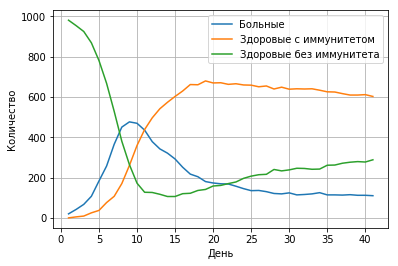

In [8]:
%%time

plt.plot([i+1 for i, _ in enumerate(ill_graph)], ill_graph, label='Больные')
plt.plot([i+1 for i, _ in enumerate(rec_graph)], rec_graph, label='Здоровые с иммунитетом')
plt.plot([i+1 for i, _ in enumerate(sus_graph)], sus_graph, label='Здоровые без иммунитета')
plt.xlabel('День')
plt.ylabel('Количество')
plt.legend()
plt.grid()

#### 1.2 Реализация с хранением состояния в hdfs

In [4]:
%%time

N = 1000
G = nx.gaussian_random_partition_graph(n=N,                 # Число вершин в графе
                                       s=6,                 # Средний размер кластеров
                                       v=4,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                       p_in=0.05,           # Вероятность ребра в кластере
                                       p_out=0.02,          # Вероятность ребра между кластерами
                                       directed=False,      # Ориентированный ли граф
                                       seed=RANDOM_SEED)

CPU times: user 96 ms, sys: 4 ms, total: 100 ms
Wall time: 103 ms


In [5]:
I = 20
ill_arr = np.random.randint(0, len(G.nodes()), I)

In [6]:
%%time

v = sqlContext.createDataFrame([(i, 1 if i in ill_arr else 0) for i in range(len(G.nodes()))], ['id', 'status'])
e = sqlContext.createDataFrame([(src, dst, 1) for src, dst in list(G.edges())], ["src","dst","relationship"])
 
g = GraphFrame(v,e)

CPU times: user 572 ms, sys: 12 ms, total: 584 ms
Wall time: 1.89 s


In [7]:
%%time

g.vertices.write.mode("overwrite").parquet("/user/mob2021045/task1_2/vertices")
g.edges.write.mode("overwrite").parquet("/user/mob2021045/task1_2/edges")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 4.45 s


In [8]:
%%time

V = sqlContext.read.parquet("/user/mob2021045/task1_2/vertices")
E = sqlContext.read.parquet("/user/mob2021045/task1_2/edges")

G = GraphFrame(V, E)

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 436 ms


In [9]:
def graph_SIRS_simulation_spark(G, V, E, beta, mu, eta, days = 1):
    n_ill_history, n_rec_history = [], []
    neighbors = G.find("(a)-[]->(b)")
    
    for day in range(days):
        vertixes_status = V.toPandas().sort_values('id').status.values.astype(np.uint8)
        ill_vertix = np.where(vertixes_status == 1)[0]
        rec_vertix = np.where(vertixes_status == 2)[0]
        
        for j, ill_ver in enumerate(ill_vertix):
            clear_output(wait=True)
            print('| Day: {}/{} | Diseased vertex: {}/{} |'.format(day+1, days, j+1, len(ill_vertix)))
            
            df = neighbors.filter('a.id == ' + str(ill_ver)).select('b').toPandas()
            neigh = [row.b.id for row in df.itertuples()]
            
            vertixes_status[neigh] += np.random.binomial(1, beta, len(neigh)).astype(np.uint8)
            vertixes_status = np.clip(vertixes_status, 0, 1)
            
        vertixes_status[ill_vertix] = 1 + np.random.binomial(1, mu, len(ill_vertix)).astype(np.uint8)
        vertixes_status[rec_vertix] = (2 + np.random.binomial(1, eta, len(rec_vertix)).astype(np.uint8)) % 3
        
        n_ill_history.append((vertixes_status == 1).sum())
        n_rec_history.append((vertixes_status == 2).sum())
        
        new_v = sqlContext.createDataFrame(
            [(i, int(status)) for i, status in enumerate(vertixes_status)], 
            ['id', 'status']
        )
        new_v.write.mode("overwrite").parquet("/user/mob2021045/task1_2/vertices")
        
        V = sqlContext.read.parquet("/user/mob2021045/task1_2/vertices").cache()
        G = GraphFrame(V, E)

    return n_ill_history, n_rec_history

In [10]:
# Зададим параметры эпидемии

beta = 0.1   # Вероятность заразиться при контакте с больным
mu   = 0.2   # Вероятность выздороветь и приобрести иммунитет
eta  = 0.05  # Вероятность утратить иммунитет

In [11]:
%%time

ill_graph, rec_graph = graph_SIRS_simulation_spark(G, V, E, beta, mu, eta, days = 5)
sus_graph = np.array([N]*len(ill_graph)) - ill_graph - rec_graph

| Day: 5/5 | Diseased vertex: 543/543 |
CPU times: user 6.87 s, sys: 972 ms, total: 7.84 s
Wall time: 3min 9s


CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 33.8 ms


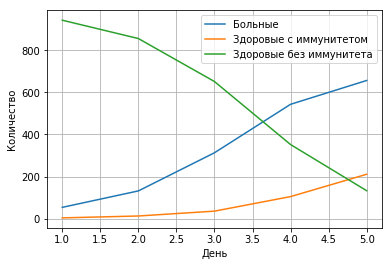

In [12]:
%%time

plt.plot([i+1 for i, _ in enumerate(ill_graph)], ill_graph, label='Больные')
plt.plot([i+1 for i, _ in enumerate(rec_graph)], rec_graph, label='Здоровые с иммунитетом')
plt.plot([i+1 for i, _ in enumerate(sus_graph)], sus_graph, label='Здоровые без иммунитета')
plt.xlabel('День')
plt.ylabel('Количество')
plt.legend()
plt.grid()

#### 1.3 Зависимость времени работы алгоритма от размера графа 

In [8]:
graph_sizes = [100, 300, 500, 700, 1000, 1500, 2500, 3500, 5000]
beta = 0.05  # Вероятность заразиться при контакте с больным
mu   = 0.2   # Вероятность выздороветь и приобрести иммунитет
eta  = 0.01  # Вероятность утратить иммунитет

In [9]:
%%time

time_results = []
for graph_size in graph_sizes:
    G = nx.gaussian_random_partition_graph(n=graph_size,        # Число вершин в графе
                                           s=6,                 # Средний размер кластеров
                                           v=4,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                           p_in=0.05,           # Вероятность ребра в кластере
                                           p_out=0.02,          # Вероятность ребра между кластерами
                                           directed=False,      # Ориентированный ли граф
                                           seed=RANDOM_SEED)
    I = 20
    ill_arr = np.random.randint(0, len(G.nodes()), I)
    
    v = sqlContext.createDataFrame([(i, 1 if i in ill_arr else 0) for i in range(len(G.nodes()))], ['id', 'status'])
    e = sqlContext.createDataFrame([(src, dst, 1) for src, dst in list(G.edges())], ["src","dst","relationship"])
    g = GraphFrame(v,e)
    
    g.vertices.write.mode("overwrite").parquet("/user/mob2021045/task1_2/vertices")
    g.edges.write.mode("overwrite").parquet("/user/mob2021045/task1_2/edges")
    
    V = sqlContext.read.parquet("/user/mob2021045/task1_2/vertices")
    E = sqlContext.read.parquet("/user/mob2021045/task1_2/edges")
    G = GraphFrame(V, E)
    
    beta = 0.1   # Вероятность заразиться при контакте с больным
    mu   = 0.2   # Вероятность выздороветь и приобрести иммунитет
    eta  = 0.05  # Вероятность утратить иммунитет
    
    start = time()
    ill_graph, rec_graph = graph_SIRS_simulation_spark(G, V, E, beta, mu, eta, days = 5)
    end = time()
    time_results.append(end - start)

| Day: 5/5 | Diseased vertex: 3678/3678 |
CPU times: user 3min 5s, sys: 24.4 s, total: 3min 30s
Wall time: 1h 1min 36s


CPU times: user 28 ms, sys: 0 ns, total: 28 ms
Wall time: 27.6 ms


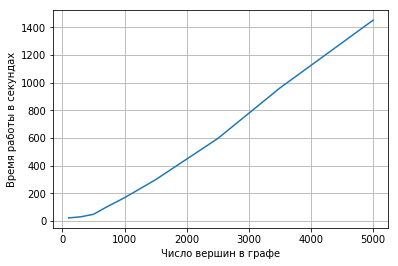

In [10]:
%%time

plt.plot(graph_sizes, time_results)
plt.xlabel('Число вершин в графе')
plt.ylabel('Время работы в секундах')
plt.grid()

---

### №2: Провести анализ способов ускорения алгоритма.

К сожалению pyspark не поддерживает формат GraphX, у которого есть полезные функции, такие как посчитать всех соседей для каждой вершины, поэтому в данном задании вам предлагается найти способ обойти это ограничение.

1. Посчитайте заранее всех соседей для всех вершин и сохраните в hdfs (просьба не генерировать слишком плотные графы, чтобы не засорять память кластера). После этого каждый раз когда будете искать соседей используйте функции спарка, чтобы получить их из вашего DataFrame. Посчитайте зависимость времени подсчет всех соседей и сохранения в систему в зависиости от размера графа (условия на размер и его генерацию возьмите из прошлого пункта)  и сравните скорость работы с алгоритмами из первого задания

2. Предложите более сильное ускорение алгоритма без хранения всех данных о графе в оперативной памяти. 

P.S. оценка за этот пункт будет зависить от элегантности и скорости предложенного методы. Может лежать в диапазоне от 0 до 15%.

#### 2.1 Заранее посчитанные соседи

In [4]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [5]:
def save_neighbors_to_spark(G, batch_size = 30):

    schema = StructType([
        StructField('id', IntegerType()),
        StructField('neighbors', ArrayType(IntegerType()))
    ])
    n = sqlContext.createDataFrame([], schema)
    n.write.mode("overwrite").parquet("/user/mob2021045/task2_1/neighbors")

    for batch_nodes in batch(list(G.nodes()), batch_size):
        n = sqlContext.createDataFrame(
            [(node, list(G.neighbors(node))) for node in batch_nodes],
            ['id', 'neighbors'],
        )
        n.write.mode("append").parquet("/user/mob2021045/task2_1/neighbors")

    n = sqlContext.read.parquet("/user/mob2021045/task2_1/neighbors")
    return n

In [6]:
def graph_SIRS_simulation_spark_saved_neighbors(G, V, E, N, beta, mu, eta, days = 1):
    n_ill_history, n_rec_history = [], []
    
    for day in range(days):
        vertixes_status = V.toPandas().sort_values('id').status.values.astype(np.uint8)
        ill_vertix = np.where(vertixes_status == 1)[0]
        rec_vertix = np.where(vertixes_status == 2)[0]
        
        for j, ill_ver in enumerate(ill_vertix):
            clear_output(wait=True)
            print('| Day: {}/{} | Diseased vertex: {}/{} |'.format(day+1, days, j+1, len(ill_vertix)))
            
            df = N.filter('id == ' + str(ill_ver)).select('neighbors').toPandas()
            neigh = df.iloc[0, 0]
            
            vertixes_status[neigh] += np.random.binomial(1, beta, len(neigh)).astype(np.uint8)
            vertixes_status = np.clip(vertixes_status, 0, 1)
            
        vertixes_status[ill_vertix] = 1 + np.random.binomial(1, mu, len(ill_vertix)).astype(np.uint8)
        vertixes_status[rec_vertix] = (2 + np.random.binomial(1, eta, len(rec_vertix)).astype(np.uint8)) % 3
        
        n_ill_history.append((vertixes_status == 1).sum())
        n_rec_history.append((vertixes_status == 2).sum())
        
        new_v = sqlContext.createDataFrame(
            [(i, int(status)) for i, status in enumerate(vertixes_status)], 
            ['id', 'status']
        )
        new_v.write.mode("overwrite").parquet("/user/mob2021045/task2_1/vertices")
        
        V = sqlContext.read.parquet("/user/mob2021045/task2_1/vertices").cache()
        G = GraphFrame(V, E)

    return n_ill_history, n_rec_history

In [7]:
graph_sizes = [100, 300, 500, 700, 1000]
beta = 0.05  # Вероятность заразиться при контакте с больным
mu   = 0.2   # Вероятность выздороветь и приобрести иммунитет
eta  = 0.01  # Вероятность утратить иммунитет

In [8]:
%%time

time_results = []
for graph_size in graph_sizes:
    G = nx.gaussian_random_partition_graph(n=graph_size,        # Число вершин в графе
                                           s=6,                 # Средний размер кластеров
                                           v=4,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                           p_in=0.05,           # Вероятность ребра в кластере
                                           p_out=0.02,          # Вероятность ребра между кластерами
                                           directed=False,      # Ориентированный ли граф
                                           seed=RANDOM_SEED)
    I = 20
    ill_arr = np.random.randint(0, len(G.nodes()), I)
    
    v = sqlContext.createDataFrame([(i, 1 if i in ill_arr else 0) for i in range(len(G.nodes()))], ['id', 'status'])
    e = sqlContext.createDataFrame([(src, dst, 1) for src, dst in list(G.edges())], ["src","dst","relationship"])
    g = GraphFrame(v,e)
    
    g.vertices.write.mode("overwrite").parquet("/user/mob2021045/task2_1/vertices")
    g.edges.write.mode("overwrite").parquet("/user/mob2021045/task2_1/edges")
    
    V = sqlContext.read.parquet("/user/mob2021045/task2_1/vertices")
    E = sqlContext.read.parquet("/user/mob2021045/task2_1/edges")
    G_hdfs = GraphFrame(V, E)
    
    start = time()
    N = save_neighbors_to_spark(G)
    ill_graph, rec_graph = graph_SIRS_simulation_spark_saved_neighbors(G_hdfs, V, E, N, beta, mu, eta, days = 5)
    end = time()
    time_results.append(end - start)

| Day: 5/5 | Diseased vertex: 145/145 |
CPU times: user 6.79 s, sys: 808 ms, total: 7.6 s
Wall time: 2min 49s


CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 33.5 ms


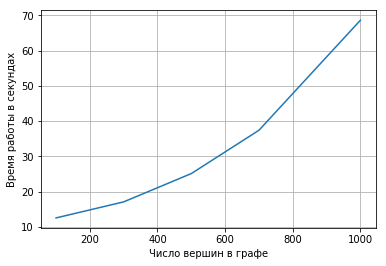

In [9]:
%%time

plt.plot(graph_sizes, time_results)
plt.xlabel('Число вершин в графе')
plt.ylabel('Время работы в секундах')
plt.grid()

#### 2.2 Свой алгоритм

In [8]:
def graph_SIRS_simulation_spark_fast(V, E, beta, mu, eta, days = 1):
    n_ill_history, n_rec_history = [], []
    vertixes_status = V
    
    for day in range(days):
        ill_vertix = np.where(vertixes_status == 1)[0]
        rec_vertix = np.where(vertixes_status == 2)[0]
        
        clear_output(wait=True)
        print('| Day: {}/{} | Diseased vertex: {} |'.format(day+1, days, len(ill_vertix)))
            
        df = E.filter(E.src.isin(ill_vertix.tolist())).groupBy('dst').count() \
              .groupBy("count").agg(F.collect_list("dst").alias('nodes')).toPandas()
        
        for row in df.itertuples():
            vertixes_status[row.nodes] = np.random.binomial(
                1,
                1 - (1 - beta)**row.count,
                len(row.nodes),
            ).astype(np.uint8)
            
        vertixes_status[ill_vertix] = 1 + np.random.binomial(1, mu, len(ill_vertix)).astype(np.uint8)
        vertixes_status[rec_vertix] = (2 + np.random.binomial(1, eta, len(rec_vertix)).astype(np.uint8)) % 3
        
        n_ill_history.append((vertixes_status == 1).sum())
        n_rec_history.append((vertixes_status == 2).sum())

    return n_ill_history, n_rec_history

In [9]:
graph_sizes = [100, 300, 500, 700, 1000, 1500, 2500, 3500, 5000]
beta = 0.05  # Вероятность заразиться при контакте с больным
mu   = 0.2   # Вероятность выздороветь и приобрести иммунитет
eta  = 0.01  # Вероятность утратить иммунитет

In [10]:
%%time

time_results = []
for graph_size in graph_sizes:
    G = nx.gaussian_random_partition_graph(n=graph_size,        # Число вершин в графе
                                           s=6,                 # Средний размер кластеров
                                           v=4,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                           p_in=0.05,           # Вероятность ребра в кластере
                                           p_out=0.02,          # Вероятность ребра между кластерами
                                           directed=False,      # Ориентированный ли граф
                                           seed=RANDOM_SEED)
    
    I = 20
    ill_arr = np.random.randint(0, len(G.nodes()), I)
    V = np.array([1 if i in ill_arr else 0 for i in range(len(G.nodes))])
    
    e = sqlContext.createDataFrame([(src, dst, 1) for src, dst in list(G.edges())], ["src","dst","relationship"])
    e.write.mode("overwrite").parquet("/user/mob2021045/task2_2/edges")
    E = sqlContext.read.parquet("/user/mob2021045/task2_2/edges")
    
    start = time()
    ill_graph, rec_graph = graph_SIRS_simulation_spark_fast(V, E, beta, mu, eta, days = 5)
    end = time()
    time_results.append(end - start)

| Day: 5/5 | Diseased vertex: 4170 |
CPU times: user 27.8 s, sys: 880 ms, total: 28.7 s
Wall time: 1min 18s


CPU times: user 36 ms, sys: 0 ns, total: 36 ms
Wall time: 36.9 ms


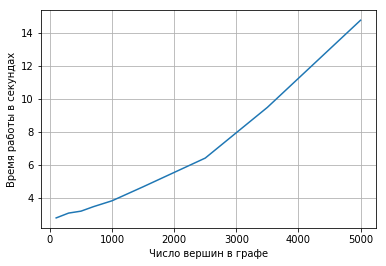

In [11]:
%%time

plt.plot(graph_sizes, time_results)
plt.xlabel('Число вершин в графе')
plt.ylabel('Время работы в секундах')
plt.grid()

---

### №3: Улучшить предсказание состояния вершины, предложенное на семинаре


1. Добавьте дополнительные признаки (от 0 до 20%):
    * Признаки, связанные с центральностями вершин.
    * Признаки, связанные с глобальными свойствами вершин -- например включена ли вершина в какую-либо клику, какой размер у этой клики, сколько ребер соединяет рассматриваемую вершину с самой центрально и т.д. (здесь вы можете проявить свои творческие способности.) 
    * Любые другие признаки, которые вам могут показаться полезными.
    
    
2. Написать функцию по генерации данных для обучения (12%):  
    Поскольку для обучение робастной модели (а тем более модели бустинга) требуется большое количество данных, необходимо:
    * Написать фунцию, которая получает на вход "средний граф" (его вы генерируете заранее), а возвращает набор из графов, полученных из "среднего" разумным процессов добавления и удаления вершин.
    * Для каждого сгенерированного графа получить несколько реализаций эпидемии.
    
    
3. Обучить модель бустинга (или любая другая на Ваше усмотрение, кроме линейной) и сравнить качество, полученное Вашей моделью с качеством, полученным моделью из семинара. (12%)

#### 3.2 Генератор данных для обучения

In [16]:
def generate_graphs(G, n_graphs = 1):

    G_full = nx.complete_graph(len(G.nodes()))
    add_edges = np.random.permutation(list(set(G_full.edges()) - set(G.edges())))
    num_edges_to_change = int(len(G.edges())*0.01)

    Gs = []
    for _ in range(n_graphs):
        G_i = deepcopy(G)

        edges_to_add = np.random.permutation(add_edges)[:num_edges_to_change]
        G_i.add_edges_from(edges_to_add)

        edges_to_remove = np.random.permutation(list(set(G.edges())))[:num_edges_to_change]
        G_i.remove_edges_from(edges_to_remove)

        Gs.append(G_i.to_undirected())

    return Gs

In [17]:
%%time

G = nx.gaussian_random_partition_graph(n=69,                # Число вершин в графе
                                       s=8,                 # Средний размер кластеров
                                       v=2,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                       p_in=0.4,            # Вероятность ребра в кластере
                                       p_out=0.2,           # Вероятность ребра между кластерами
                                       directed=False,      # Ориентированный ли граф
                                       seed=RANDOM_SEED)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 6.05 ms


In [18]:
%%time

Gs = generate_graphs(G, n_graphs = 10)

CPU times: user 68 ms, sys: 8 ms, total: 76 ms
Wall time: 81.1 ms


In [19]:
def generate_epidemic_realizations(Gs, beta, sigma, gamma, xi, n_sample = 5, max_day = 64):
    DATA = []

    for G_i in tqdm(Gs):
        data = []
        for n in range(n_sample):
            Xs = {}
            SEIRmodel = SEIRSNetworkModel(G          = G_i.to_undirected(), 
                                          beta       = beta,
                                          sigma      = sigma, 
                                          gamma      = gamma,  
                                          xi         = xi, 
                                          initI      = int(len(G_i.nodes())/5),
                                          isolation_time = 0)

            for i in range(max_day):
                Xs[i] = dict(enumerate((SEIRmodel.X.copy()).T[0]))
                SEIRmodel.run(T=1, verbose = -1)
                
            data.append(Xs)    
        DATA.extend(data)
        
    return DATA

In [20]:
# Параметры эпидемии:
BETA  = 0.3
SIGMA = 0.64
GAMMA = 0.14
XI    = 0.09

In [21]:
%%time

DATA = generate_epidemic_realizations(Gs, BETA, SIGMA, GAMMA, XI, n_sample = 10, max_day = 64)

100%|██████████| 10/10 [00:25<00:00,  2.58s/it]

CPU times: user 25.8 s, sys: 60 ms, total: 25.9 s
Wall time: 25.9 s


In [22]:
%%time

average_data = defaultdict(dict)
for day in range(len(DATA[0])):
    for node in range(len(DATA[0][0])):
        values = []
        for i in range(len(DATA)):
            if DATA[i][day][node] == 3:
                values.append(1.)
            elif DATA[i][day][node] == 2 or DATA[i][day][node] == 4:
                values.append(0.95)
            else:
                values.append(0.)
        average_data[day][node] = np.mean(values)

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 339 ms


#### 3.1 Дополнительные признаки для вершин и генерация датасета

In [23]:
def create_dateset(G, data, past_days = 5, future = 1):
    
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    load_centrality = nx.load_centrality(G)
    square_clustering = nx.square_clustering(G)
    clustering = nx.clustering(G)
    node_clique_number = nx.node_clique_number(G)
    number_of_cliques = nx.number_of_cliques(G)
    
    Gs = []
    for day in data:
        g = deepcopy(G)
        Nodes = g.nodes(data=True)
        for ver in data[day]:
            Nodes[ver]['mark'] = 1 if data[day][ver] >= 0.5 else 0
        Gs.append(g)
        
    X = [] # np.zeros((len(G.nodes()), 2 * past_days))
    Y = []
    for i in range(past_days + future - 1, len(data) - 1):
        for node, mark in Gs[i].nodes(data=True):
            Y.append(mark['mark'])
            x = []
            for j in range(i - future, i - past_days - future, -1):
                nodes = Gs[j].nodes(data=True)
                x.append(nodes[node]['mark'])
                all_contacts = 0
                ill_contacts = 0
                for neigh in Gs[j].neighbors(node):
                    all_contacts += 1
                    ill_contacts += nodes[neigh]['mark']
                x.append(all_contacts)
                x.append(ill_contacts)
            
            x.append(degree_centrality[node])
            x.append(closeness_centrality[node])
            x.append(betweenness_centrality[node])
            x.append(load_centrality[node])
            x.append(square_clustering[node])
            x.append(clustering[node])
            x.append(node_clique_number[node])
            x.append(number_of_cliques[node])
            
            X.append(x)
            
    return X, Y

In [24]:
%%time

X1, Y1 = create_dateset(G.to_undirected(), average_data, past_days = 5, future = 1)

CPU times: user 620 ms, sys: 4 ms, total: 624 ms
Wall time: 622 ms


#### 3.3 Обучение модели 
Метрики на валидации лучше (граф сгенерирован с аналогичными параметрами), чем на семинаре.

С семинара:
- ROC-AUC: 0.9203619284431551
- Precision: 0.8734693877551021
- Recall: 0.84251968503937
- RMSE: 0.04228293587546049

Мои:
- ROC-AUC: 0.9451338101743952
- Precision: 0.8843683083511777
- Recall: 0.8978260869565218
- RMSE: 0.08308264064471049

In [25]:
%%time

model = CatBoostClassifier(verbose=False)

X_train, X_test, y_train, y_test = train_test_split(X1, Y1, stratify=Y1, random_state = abs(RANDOM_SEED))
model.fit(X_train, y_train)

print(y_test[:10])
print(model.predict_proba(X_test)[:10, 1])
print('==='*10)
print('ROC-AUC:', roc_auc_score(y_test, model.predict_proba(X_test)[:,1]))
print('Precision:', precision_score(y_test, model.predict(X_test)))
print('Recall:', recall_score(y_test, model.predict(X_test)))
print('RMSE:', mean_squared_error(y_test, model.predict_proba(X_test)[:,1]))

Learning rate set to 0.022866
[1, 0, 0, 0, 1, 1, 1, 1, 0, 1]
[0.5869093  0.03515413 0.04430042 0.08038841 0.95448887 0.15849318
 0.95161129 0.77110971 0.12939173 0.13595601]
ROC-AUC: 0.9451338101743952
Precision: 0.8843683083511777
Recall: 0.8978260869565218
RMSE: 0.08308264064471049
CPU times: user 1min, sys: 11.2 s, total: 1min 11s
Wall time: 7.96 s


---

### №4: Обобщите модель из первого пункта на случай 4 классов (модель SEIRS) (15%)

In [4]:
%%time

N = 1000
G = nx.gaussian_random_partition_graph(n=N,                 # Число вершин в графе
                                       s=6,                 # Средний размер кластеров
                                       v=4,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                       p_in=0.05,           # Вероятность ребра в кластере
                                       p_out=0.02,          # Вероятность ребра между кластерами
                                       directed=False,      # Ориентированный ли граф
                                       seed=RANDOM_SEED)

CPU times: user 100 ms, sys: 0 ns, total: 100 ms
Wall time: 102 ms


In [5]:
I = 20
ill_arr = np.random.randint(0, len(G.nodes()), I)

In [6]:
%%time

v = sqlContext.createDataFrame([(i, 2 if i in ill_arr else 0) for i in range(len(G.nodes()))], ['id', 'status'])
e = sqlContext.createDataFrame([(src, dst, 1) for src, dst in list(G.edges())], ["src","dst","relationship"])
g = GraphFrame(v,e)

g.vertices.write.mode("overwrite").parquet("/user/mob2021045/task4/vertices")
g.edges.write.mode("overwrite").parquet("/user/mob2021045/task4/edges")

V = sqlContext.read.parquet("/user/mob2021045/task4/vertices")
E = sqlContext.read.parquet("/user/mob2021045/task4/edges")
G = GraphFrame(V, E)

CPU times: user 568 ms, sys: 16 ms, total: 584 ms
Wall time: 6.02 s


In [7]:
def graph_SEIRS_simulation_spark(G, V, E, beta, sigma, gamma, omega, days = 1):
    n_ill_history, n_rec_history, n_exp_history = [], [], []
    neighbors = G.find("(a)-[]->(b)")
    
    for day in range(days):
        vertixes_status = V.toPandas().sort_values('id').status.values.astype(np.uint8)
        exp_vertix = np.where(vertixes_status == 1)[0]
        ill_vertix = np.where(vertixes_status == 2)[0]
        rec_vertix = np.where(vertixes_status == 3)[0]
        
        for j, ill_ver in enumerate(ill_vertix):
            clear_output(wait=True)
            print('| Day: {}/{} | Diseased vertex: {}/{} |'.format(day+1, days, j+1, len(ill_vertix)))
            
            df = neighbors.filter('a.id == ' + str(ill_ver)).select('b').toPandas()
            neigh = [row.b.id for row in df.itertuples()]
            
            vertixes_status[neigh] = np.random.binomial(1, beta, len(neigh)).astype(np.uint8)
        
        vertixes_status[exp_vertix] = 1 + np.random.binomial(1, sigma, len(exp_vertix)).astype(np.uint8)
        vertixes_status[ill_vertix] = 2 + np.random.binomial(1, gamma, len(ill_vertix)).astype(np.uint8)
        vertixes_status[rec_vertix] = (3 + np.random.binomial(1, omega, len(rec_vertix)).astype(np.uint8)) % 4
        
        n_exp_history.append((vertixes_status == 1).sum())
        n_ill_history.append((vertixes_status == 2).sum())
        n_rec_history.append((vertixes_status == 3).sum())
        
        new_v = sqlContext.createDataFrame(
            [(i, int(status)) for i, status in enumerate(vertixes_status)], 
            ['id', 'status']
        )
        new_v.write.mode("overwrite").parquet("/user/mob2021045/task4/vertices")
        
        V = sqlContext.read.parquet("/user/mob2021045/task4/vertices").cache()
        G = GraphFrame(V, E)

    return n_exp_history, n_ill_history, n_rec_history

In [8]:
# Зададим параметры эпидемии

beta  = 0.1   # Вероятность заразиться в скрытой форме при контакте с больным
sigma = 0.5   # Вероятность перехода скрытой формы в заражение
gamma = 0.2   # Вероятность выздороветь и приобрести иммунитет
omega = 0.01  # Вероятность утратить иммунитет

In [9]:
%%time

exp_graph, ill_graph, rec_graph = graph_SEIRS_simulation_spark(G, V, E, beta, sigma, gamma, omega, days = 8)
sus_graph = np.array([N]*len(ill_graph)) - ill_graph - rec_graph - exp_graph

| Day: 8/8 | Diseased vertex: 163/163 |
CPU times: user 3.78 s, sys: 664 ms, total: 4.44 s
Wall time: 1min 40s


CPU times: user 32 ms, sys: 4 ms, total: 36 ms
Wall time: 38.3 ms


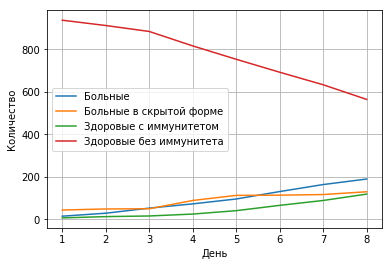

In [10]:
%%time

plt.plot([i+1 for i, _ in enumerate(ill_graph)], ill_graph, label='Больные')
plt.plot([i+1 for i, _ in enumerate(exp_graph)], exp_graph, label='Больные в скрытой форме')
plt.plot([i+1 for i, _ in enumerate(rec_graph)], rec_graph, label='Здоровые с иммунитетом')
plt.plot([i+1 for i, _ in enumerate(sus_graph)], sus_graph, label='Здоровые без иммунитета')
plt.xlabel('День')
plt.ylabel('Количество')
plt.legend()
plt.grid()

## ---

### №5*: Обобщить задачу из предыдущего пункта на случай не стационарного графа (15%)


In [4]:
%%time

N = 1000
G = nx.gaussian_random_partition_graph(n=N,                 # Число вершин в графе
                                       s=6,                 # Средний размер кластеров
                                       v=4,                 # Параметр, отвечающий за дисперсию среднего размера кластера
                                       p_in=0.05,           # Вероятность ребра в кластере
                                       p_out=0.02,          # Вероятность ребра между кластерами
                                       directed=False,      # Ориентированный ли граф
                                       seed=RANDOM_SEED)

CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 97.2 ms


In [5]:
I = 20
ill_arr = np.random.randint(0, len(G.nodes()), I)

In [6]:
%%time

v = sqlContext.createDataFrame([(i, 2 if i in ill_arr else 0) for i in range(len(G.nodes()))], ['id', 'status'])
e = sqlContext.createDataFrame([(src, dst, 1) for src, dst in list(G.edges())], ["src","dst","relationship"])
g = GraphFrame(v,e)

g.vertices.write.mode("overwrite").parquet("/user/mob2021045/task5/vertices")
g.edges.write.mode("overwrite").parquet("/user/mob2021045/task5/edges")

V = sqlContext.read.parquet("/user/mob2021045/task5/vertices")
E = sqlContext.read.parquet("/user/mob2021045/task5/edges")
G = GraphFrame(V, E)

CPU times: user 556 ms, sys: 0 ns, total: 556 ms
Wall time: 5.47 s


In [7]:
def graph_SEIRS_simulation_spark_nonstationary(G, V, E, beta, sigma, gamma, omega, dropout_prob, days = 1):
    n_ill_history, n_rec_history, n_exp_history = [], [], []
    
    for day in range(days):
        vertixes_status = V.toPandas().sort_values('id').status.values.astype(np.uint8)
        exp_vertix = np.where(vertixes_status == 1)[0]
        ill_vertix = np.where(vertixes_status == 2)[0]
        rec_vertix = np.where(vertixes_status == 3)[0]
        
        for j, ill_ver in enumerate(ill_vertix):
            clear_output(wait=True)
            print('| Day: {}/{} | Diseased vertex: {}/{} |'.format(day+1, days, j+1, len(ill_vertix)))
            
            df = E.cache().filter('relationship == 1 AND src == ' + str(ill_ver)).select('dst').toPandas()
            neigh = list(df['dst'])
            
            vertixes_status[neigh] = np.random.binomial(1, beta, len(neigh)).astype(np.uint8)
        
        vertixes_status[exp_vertix] = 1 + np.random.binomial(1, sigma, len(exp_vertix)).astype(np.uint8)
        vertixes_status[ill_vertix] = 2 + np.random.binomial(1, gamma, len(ill_vertix)).astype(np.uint8)
        vertixes_status[rec_vertix] = (3 + np.random.binomial(1, omega, len(rec_vertix)).astype(np.uint8)) % 4
        
        n_exp_history.append((vertixes_status == 1).sum())
        n_ill_history.append((vertixes_status == 2).sum())
        n_rec_history.append((vertixes_status == 3).sum())
        
        new_v = sqlContext.createDataFrame(
            [(i, int(status)) for i, status in enumerate(vertixes_status)], 
            ['id', 'status']
        )
        new_v.write.mode("overwrite").parquet("/user/mob2021045/task5/vertices")
        
        new_e = E.select('src', 'dst').withColumn(
            'relationship',
            F.when(F.rand() < dropout_prob, 0).otherwise(1),
        )
        new_e.repartition(10).write.mode("overwrite").parquet("/user/mob2021045/task5/edges")
        
        
        V = sqlContext.read.parquet("/user/mob2021045/task5/vertices").cache()
        E = sqlContext.read.parquet("/user/mob2021045/task5/edges")
        G = GraphFrame(V, E)

    return n_exp_history, n_ill_history, n_rec_history

In [8]:
# Зададим параметры эпидемии

beta  = 0.1   # Вероятность заразиться в скрытой форме при контакте с больным
sigma = 0.5   # Вероятность перехода скрытой формы в заражение
gamma = 0.2   # Вероятность выздороветь и приобрести иммунитет
omega = 0.01  # Вероятность утратить иммунитет

dropout_prob = 0.05  # Вероятность выкинуть ребро графа

In [9]:
%%time

exp_graph, ill_graph, rec_graph = graph_SEIRS_simulation_spark_nonstationary(
    G, V, E, beta, sigma, gamma, omega, dropout_prob, days = 8
)
sus_graph = np.array([N]*len(ill_graph)) - ill_graph - rec_graph - exp_graph

| Day: 8/8 | Diseased vertex: 128/128 |
CPU times: user 2.48 s, sys: 500 ms, total: 2.98 s
Wall time: 41.3 s


CPU times: user 40 ms, sys: 0 ns, total: 40 ms
Wall time: 36 ms


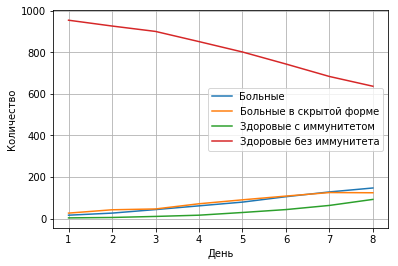

In [10]:
%%time

plt.plot([i+1 for i, _ in enumerate(ill_graph)], ill_graph, label='Больные')
plt.plot([i+1 for i, _ in enumerate(exp_graph)], exp_graph, label='Больные в скрытой форме')
plt.plot([i+1 for i, _ in enumerate(rec_graph)], rec_graph, label='Здоровые с иммунитетом')
plt.plot([i+1 for i, _ in enumerate(sus_graph)], sus_graph, label='Здоровые без иммунитета')
plt.xlabel('День')
plt.ylabel('Количество')
plt.legend()
plt.grid()

---